# Data Gathering and merging

Since the used sensor system is sending the data to the cloud ThinkSpeak we have to implement a way, how to get the data from the internet and store it locally. In order to do so we first have to load the data, which is already stored on the computer. Then a pull request is made containing the last timestamp of the CSV data. This way it is not necessary to always download all data. Then the data has to brought in the right format, so that it then can be merged to the file on the computer.

In [7]:
import requests
import pandas as pd
import numpy as np

def get_data_from_CSV(file_path, column_names=['time', 'pH', 'EC', 'ORP', 'Temperature']):
    '''
    Function to get data from a CSV file
    '''

    data = pd.read_csv(file_path)
    data.columns = column_names
    if 'time' in data.columns:
        data['time'] = pd.to_datetime(data['time'])
        data.set_index('time', inplace=True)

    return data

def get_data_from_API(channel_id, api_key, timestamp):
    '''
    Function to get data from the ThingSpeak API
    '''

    get_url = f'https://api.thingspeak.com/channels/{channel_id}/feeds.csv?api_key={api_key}&start={timestamp}'
    response = requests.get(get_url)

    if response.status_code == 200:
        new_data = pd.read_csv(get_url)
        new_data = new_data[1:]     # remove first row (its the last entry from the last update)
    
    return new_data

def strip_data(data, column_names=['time', 'pH', 'EC', 'ORP', 'Temperature']):
    #TODO: + one hour to the time (Das fucked halt meine Listen mit den wichtigen Daten ab...)
    '''
    Function to strip the data from the API response. This is necessary because the API response contains a lot of unnecessary/empty information.
    '''

    data = data.drop(data.columns[[1]], axis=1)
    data = data.drop(data.columns[[5,6]], axis=1)      # remove unnecessary columns

    # Set the correct column names and convert the time column to datetime:
    data.columns = column_names
    data['time'] = data['time'].str.replace(' UTC', '')
    data['time'] = pd.to_datetime(data['time'])
    data.set_index('time', inplace=True)

    # Remove zeros from value columns and replace them with the value of the previous row:
    for value_name in data.columns[1:]:
        prev_value = np.nan
        for index, value in data[value_name].items():
            if value == 0:
                data.at[index, value_name] = prev_value
            else:
                prev_value = value
    return data

def merge_data(new_data, old_data):
    # This function merges the new data with the old data
    data = pd.concat([old_data, new_data])
    data = data[~data.index.duplicated(keep='last')] # remove duplicates
    return data

def remove_outliers(data, threshold):
    #TODO: This function is not working properly yet
    '''
    This function removes outliers from the given data and returns the cleaned data
    The threshold defines the maximum difference between two values
    It's an simple algorithm that replaces outliers with the avarage of the previous and the next value
    '''

    avarage = data.iloc[:4].sum() / 4   # Calculate the avarage of the first 6 values
    
    for index, value in enumerate(data):
        if index <= 4 or index >= len(data) - 4:  # Skip first and last four value
            continue

        elif abs(value - avarage) > threshold:
            # First we have to calculate the avarage of the next 4 values
            # This helps to prevent that fast changes in the data are recognized as outliers, which especially important for EC
            next_avarage = data.iloc[index+1:index+5].sum() / 4 
            if abs(value - next_avarage) > threshold:
                # If the next value is also an outlier, we replace it with the avarage of the previous and the next value
                data.at[index] = round(avarage, 1)
                avarage = (data.iloc[index-1] + data.iloc[index+1]) / 2
            else:
                continue
        else:
            pass

        avarage = data.iloc[index-4:index].sum() / 4
    return data

def remove_outliers2(data, threshold):
    """
    Diese Funktion entfernt Ausreißer aus einem Datensatz.
    
    :param data: Der Eingabedatensatz (Pandas DataFrame).
    :param threshold: Der Schwellenwert für Ausreißer.
    :return: Der bereinigte Datensatz ohne Ausreißer.
    """
    # Kopie des Originaldatensatzes erstellen, um die Originaldaten nicht zu ändern
    cleaned_data = data.copy()

    # Unterschiede zwischen aufeinanderfolgenden Werten berechnen
    differences = np.abs(cleaned_data - cleaned_data.shift(1))

    # Werte über dem Threshold als Ausreißer betrachten und durch NaN ersetzen
    cleaned_data[differences > threshold] = cleaned_data.shift(-1)

    # NaN-Werte entfernen
    cleaned_data = cleaned_data.dropna()

    return cleaned_data


### Use the functions above:

In [8]:
# Get the data from the CSV file:
old_data = get_data_from_CSV('data.csv')

# Get the last timestamp from the old data:
timestamp = old_data.iloc[-1].name
timestamp = timestamp.strftime('%Y-%m-%dT%H:%M:%S')  

# ThinkSpeak data:
channel_id = '2022980'
api_key =  'JHMCEUJFTGCPYDZK'

# Get the new data and strip it:
new_data = get_data_from_API(channel_id, api_key, timestamp)
new_data = strip_data(new_data)

# Remove outliers from pH and ORP only:
pH_threshold = 0.06
ORP_threshold = 1

#old_data['pH'] = remove_outliers2(old_data['pH'], pH_threshold)         # Uncomment this line if you want to remove outliers from the old data
#old_data['ORP'] = remove_outliers2(old_data['ORP'], ORP_threshold)       # Uncomment this line if you want to remove outliers from the old data
new_data['pH'] = remove_outliers(new_data['pH'], pH_threshold)
new_data['ORP'] = remove_outliers(new_data['ORP'], ORP_threshold)

# Merge the new data with the old data and save it to a csv file:
complete_data = merge_data(new_data, old_data)
complete_data.to_csv('data.csv')

# The Significance of Data Visualization in Unveiling Patterns and Insights

In the realm of data-driven decision-making, the significance of effective data visualization cannot be overstated. As we navigate through complex datasets, the ability to distill patterns and insights from raw information becomes a critical aspect of understanding the underlying dynamics. Visualization serves as the bridge between data and comprehension, facilitating a more intuitive grasp of trends, anomalies, and relationships within the dataset.

## Unveiling Patterns in Temporal Dynamics

When dealing with sensor data, especially over time, the need for precise temporal insights becomes paramount. A well-crafted data visualization not only enhances our understanding of events but also enables the identification of patterns and anomalies that might be elusive in raw numerical formats.

In our ongoing project, we have developed a robust data visualization function tailored to provide a dynamic exploration of sensor events. This function is designed to offer unparalleled flexibility, allowing users to specify start and end dates to focus on specific time frames. By doing so, we empower analysts to zoom in on critical periods, uncovering trends that might be hidden in the broader dataset.

## Feature-Specific Analysis for Deeper Understanding

Our visualization function goes beyond mere temporal constraints; it provides the ability to isolate and explore individual features. This feature-specific analysis allows users to deep-dive into the behavior of specific variables, aiding in the identification of correlations and dependencies that might influence overall system performance.


## Streamlining the Visualization Process

To further streamline the analysis, we have incorporated a function for saving plots. This feature not only facilitates seamless documentation but also ensures that key visualizations can be shared, enhancing collaborative decision-making processes.


## Example Usage

Consider the scenario where you need to find the start and time of an event you want to predict. The ability to some in and out in the data helps you set this point right where you need it. With my function, generating a customized plot for this specific time frame becomes a seamless process, providing a visual story of sensor data during those crucial moments. In essence, this self-crafted data visualization tool serves as a personalized lens, allowing me to explore my sensor data in a way that resonates with the intricacies and nuances of my individual project.

In [9]:
def smoothing(data, window_size):
    '''
    This function smooths the data by calculating the average of the values in a window around the current value
    '''
    
    smoothed_data = []
    for i in range(len(data)):
        if i < window_size:
            smoothed_data.append(sum(data[:i+window_size+1]) / (i+window_size+1))   # average of the first values
        elif i >= len(data) - window_size:
            smoothed_data.append(sum(data[i-window_size:]) / (len(data) - i + window_size))
        else:
            smoothed_data.append(sum(data[i-window_size:i+window_size+1]) / (2*window_size + 1))
    return smoothed_data

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as md
import os

def plot_data(features: list[str], data, start_date: str = None, end_date: str = None, window_size: int = 20, save: str = False, important_dates: list = [], date_format: str = '%d.%m.%y', colors = ['red', 'green', 'darkblue', 'orange']):
    '''
    This function plots the given data from start date to end date.

    Inputs:
    features: list of strings with the names of the features to plot
    start_date: string with the start date in the format 'YYYY-MM-DD HH:MM:SS'
    end_date: string with the end date in the format 'YYYY-MM-DD HH:MM:SS'
    data: pandas dataframe with the data. Format: ['time', 'pH', 'EC', 'ORP', 'Temperature']
    window_size: integer with the size of the window for smoothing the data
    save: string with the name of the file to save the plot
    important_dates: list of strings with the dates to mark in the plot
    '''

    # Define colors and labels of the plots:
    labels = ['pH', 'EC in $\mu$S/cm', 'ORP in mV', 'Temperature in °C']
    
    # Cut the data to the given start and end date, if given:
    if start_date is not None:
        data = data.loc[start_date:]
    if end_date is not None:
        data = data.loc[:end_date]
        
    number_of_plots = len(features)    # -1 because the time is not a feature
    subplot_number = 1

    plt.figure('Data Plot', figsize=(19, 14))       # was always 19, 9

    # Hoffentlich funktioniert das:
    #[1:]
    for feature in features:
        if feature == 'time':
            continue

        plt.subplot(number_of_plots, 1, subplot_number)
        plt.plot(data.index, data[feature], '.C7', markeredgecolor='none', alpha = 0.3)
        plt.plot(data.index, smoothing(data[feature], window_size), label=feature, color = colors[subplot_number-1])
        plt.ylabel(labels[subplot_number-1])
        #plt.legend(loc = "upper left")
        plt.xlim(data.index[0], data.index[-1])
        plt.grid(axis='y')

        ax = plt.gca()
        for date in important_dates:
            ax.axvline(pd.to_datetime(date), color='red', linestyle='--', linewidth=0.5)
        
        #plt.axvline(x=['2023-12-09 10:27:15'], color='black', linestyle='-', label='Split', linewidth=2.5)
        #plt.axvspan('2024-01-28 23:59:24', data[feature].index[-1], alpha=0.2, color='gray')
        #if subplot_number == 1:
        #    plt.text(data.index[10000], max(data[feature])-0.1, 'Trainings data', color='black', fontsize=28)
        #    plt.text(data.index[-5500], max(data[feature])-0.1, 'Test data', color='black', fontsize=28)

        subplot_number += 1


    # Settings
    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.rcParams['font.size'] = 14             # general font size
    plt.rcParams['axes.titlesize'] = 30        # axis title size
    plt.rcParams['axes.labelsize'] = 30        # y axis label size
    plt.rcParams['xtick.labelsize'] = 26       # x tick label size
    plt.rcParams['ytick.labelsize'] = 26       # y tick label size
    plt.rcParams['legend.fontsize'] = 18
    plt.rcParams['legend.handlelength'] = 1.5
    plt.rcParams['figure.titlesize'] = 14 
    plt.rcParams['axes.labelpad'] = 20

    xfmt = md.DateFormatter(date_format)       # Format of the x-axis labels
    ax.xaxis.set_major_formatter(xfmt)
    plt.xlabel("Date and time")
    plt.gcf().autofmt_xdate()   # Rotate the x-axis labels for better readability
    plt.tight_layout(pad=0.8)

    # Save plot:
    if save:
        current_directory = os.getcwd()
        #pic_directory = os.path.join(current_directory, 'Bilder')
        filename = os.path.join(current_directory, f"{save}")
        plt.savefig(filename)

    plt.show()

In [11]:
# Feedings:
feeding_dates_complete = ['2023-12-05 08:32:30', '2023-12-07 07:45:47', '2023-12-09 08:05:46', '2023-12-09 09:30:03', '2023-12-13 12:48:30', '2023-12-16 09:09:08', '2023-12-19 11:24:27', '2023-12-25 08:22:57', '2023-12-29 10:33:13', '2023-12-31 11:44:29', '2024-01-03 13:47:15', '2024-01-10 13:39:25', '2024-01-16 13:51:23', '2024-01-19 15:35:29', '2024-01-23 11:23:24', '2024-01-23 13:11:40', '2024-01-26 14:37:10']
feeding_amounts = [6, 6.5, 6, 6, 9.8, 6.3, 7.3, 7.6, 7, 10, 7]  # in g

# Water refills:
refill_dates = ['2023-12-02 17:12:34', '2023-12-25 07:49:51', '2024-01-11 11:55:04']
water_refill_amounts = [4, 4, 10]

# Nutrient boosts:
boost_dates = ['2023-12-08 13:37:53', '2024-01-24 07:30:45']
boost_amounts = [1.56]

# Other:
other_dates = ['2023-12-20 15:17:04', '2024-01-05 10:06:57']        # Reinigung Syphon, Pumpenausfall

test_dates = ['2024-01-29 10:52:06', '2024-02-02 11:28:51', '2024-02-04 10:45:43', '2024-02-06 11:29:56', '2024-02-08 07:19:32', '2024-02-11 08:37:17']   # Boost + Refill, Feeding, little Boost, Feeding, Refill, Feeding

normal_dates = ['2023-12-22 13:35:38', '2023-12-22 04:37:10', '2024-01-25 06:25:46', '2023-12-12 04:02:23', '2024-01-02 07:03:35', '2024-01-08 05:29:57', '2024-01-15 05:59:33', '2024-01-09 08:04:28', '2024-01-09 15:02:36', '2023-12-03 04:29:58', '2023-12-03 17:02:36', '2023-12-04 03:07:55', '2023-12-05 01:10:00', '2023-12-07 00:23:12', '2023-12-08 03:02:43', '2023-12-11 12:01:49', '2023-12-12 08:57:32', '2023-12-21 04:02:40', '2023-12-22 06:55:31', '2023-12-23 07:29:34', '2023-12-14 06:58:51', '2023-12-14 14:15:23', '2023-12-14 19:04:23', '2023-12-15 15:20:48', '2023-12-15 05:03:33', '2023-12-16 05:59:34', '2023-12-17 12:59:05', '2023-12-17 05:54:51', '2023-12-18 20:58:04', '2023-12-18 18:00:39', '2023-12-18 06:01:47', '2023-12-19 04:01:57', '2023-12-20 02:44:44', '2023-12-21 08:54:33', '2023-12-21 21:08:58', '2023-12-22 18:48:29', '2023-12-22 12:08:24', '2023-12-23 20:22:55', '2023-12-23 13:24:38', '2023-12-30 08:39:53', '2023-12-30 15:32:04', '2024-01-01 17:07:17', '2024-01-02 18:02:24', '2024-01-24 11:31:22', '2023-12-14 13:24:12', '2024-01-29 14:34:42', '2024-01-08 17:32:01', '2024-02-02 12:53:04', '2024-01-08 08:51:28', '2024-01-08 07:42:18', '2024-01-31 21:07:31','2024-02-01 19:56:19', '2024-02-02 11:22:50']  # Last dates is getting interpretated as Feeding but no feeding happened 

# removed from normal: '2024-01-31 05:23:00',

important_dates = feeding_dates_complete + refill_dates + boost_dates + other_dates + test_dates

### Use the function:

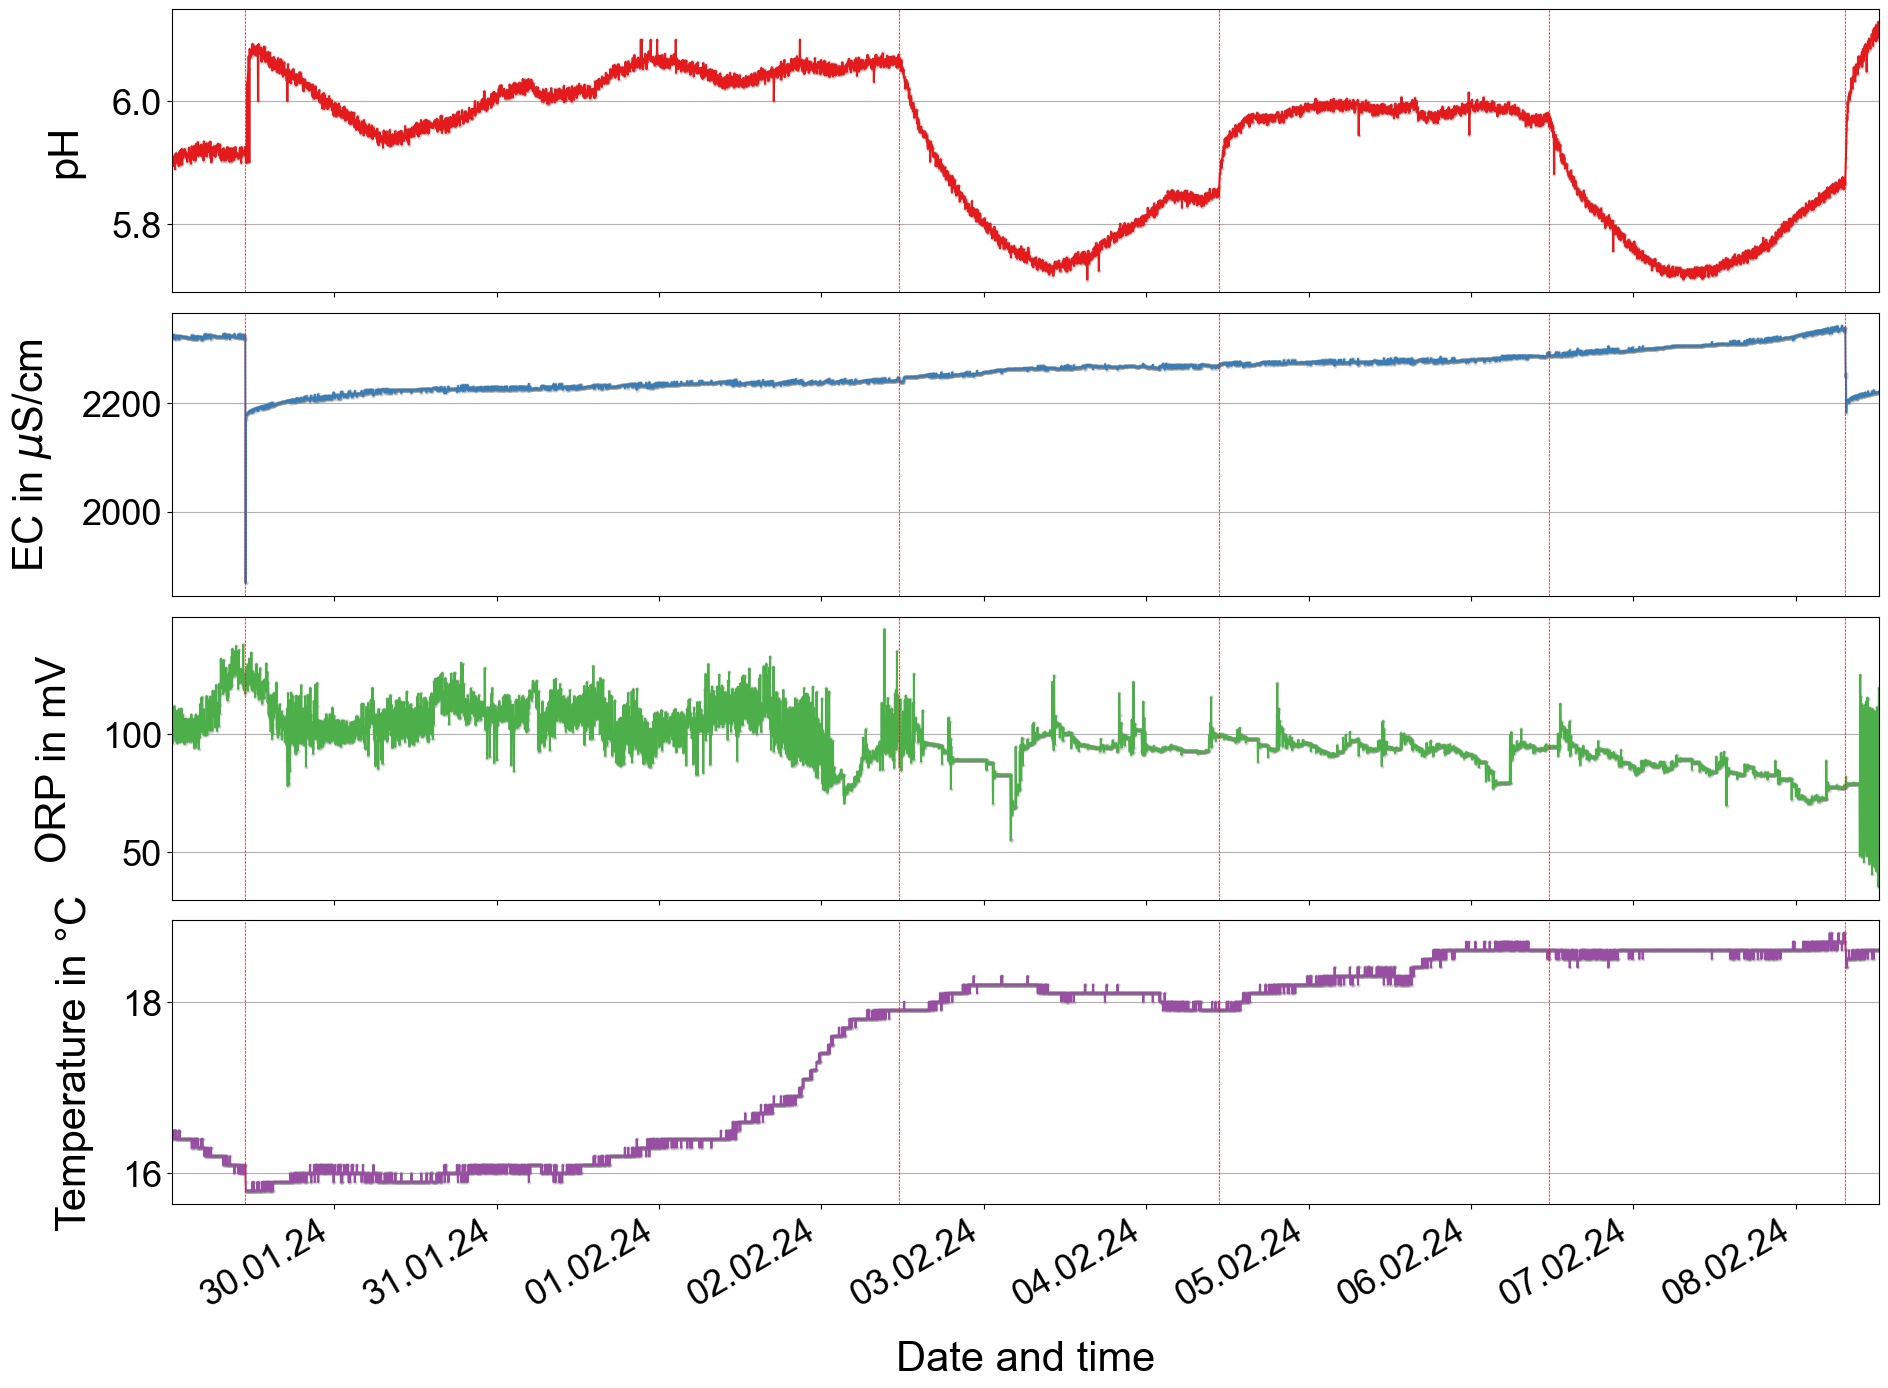

In [20]:
import seaborn as sns
colors = sns.color_palette("Set1", n_colors=4)      # Creates a list of colors for the plot

features = ['pH', 'EC', 'ORP', 'Temperature']
start_date = '2024-01-29 00:02:24'
end_date = '2024-02-08 12:17:28'
#date_fomat = '%d.%m.%y %H:%M'
date_fomat = '%d.%m.%y'

# start_date=start_date, end_date=end_date,
plot_data(features, complete_data, important_dates=test_dates, start_date=start_date, end_date=end_date, window_size=0, date_format=date_fomat, colors=colors) 

# Nurturing Machine Learning: The Vital Role of Data Preprocessing

In the realm of machine learning, the success of a model often hinges on the meticulous preparation of data before it undergoes the training process. Data preprocessing, a critical phase in this journey, involves transforming raw data into a format that is conducive to effective learning. In my recent endeavors, especially in the context of a sensor system project, the significance of thoughtful data preprocessing has become abundantly clear.

## Unveiling Temporal Patterns through Time Windows

One of the key challenges I encountered revolved around leveraging temporal patterns within the sensor data. Events unfold over time, and capturing the essence of these occurrences necessitated the creation of time windows. Each event, be it a water refill, nutrient boost, or syphon cleaning, required a nuanced approach. By segmenting the temporal landscape into distinct time windows for each event, I could offer my machine learning model a granular view, facilitating a more precise understanding of temporal dynamics.

## Addressing Data Scarcity: A Window into Limited Events

However, the journey wasn't without its hurdles. In particular, certain events like water refills, nutrient boosts, and syphon cleaning were sparsely represented in the dataset. The scarcity of data for these critical events posed a challenge, potentially hindering the model's ability to grasp the intricacies associated with them. Faced with this dilemma, I devised a creative solution – the strategic movement of time windows over these specific events.

## Unleashing the Power of Limited Data

In essence, I extended the impact of the limited data available for these events by dynamically shifting and overlapping time windows. This ingenious maneuver not only augmented the volume of data available for training but also provided the model with a more comprehensive view of the patterns associated with water refills, nutrient boosts, and syphon cleaning.

## A Balancing Act: Precision and Resourcefulness

The process underscored the delicate balance between precision and resourcefulness in data preprocessing. While the creation of time windows ensured a fine-grained analysis of temporal patterns, the adaptive handling of limited data showcased the ingenuity required to maximize the potential of every piece of information.

In conclusion, the journey through data preprocessing for my machine learning project has been a testament to the artistry involved in preparing data for model training. The creation of time windows, coupled with innovative strategies to address data scarcity, serves as a testament to the dedication required to unlock the true potential of machine learning in the context of sensor system data.

In [13]:
#TODO: Make two functions out of this
def create_train_set(data, feeding_dates=[], refill_dates=[], boost_dates=[], other_dates=[], normal_dates=[], TIME_WINDOW=60, RATIO=0.1):
    '''
    This function creates the training/test set for the given data and the given events.
    It gives each date inserted a unique ID and returns the ID dictionary.
    Maybe the end of the feedings will have to be added, in order to detect those parts as well!
    '''
    
    train_set = pd.DataFrame(columns=['time', 'ID', 'pH', 'EC', 'ORP', 'Temperature'])
    train_set.set_index('time', inplace=True)

    ID = 0
    ID_DICT = {'Feedings': [], 'Refills': [], 'Boosts': [], 'Cleaning': [], 'Normal': []}    # Save the ID of the measurement and the corresponding date

    # Add feeding windows to the train set:
    for date in feeding_dates:
        current_index = data.index.get_loc(date)        # Get the index of the date in the data

        feeding = data.iloc[current_index - int(TIME_WINDOW * RATIO) : current_index + int(TIME_WINDOW * (1 - RATIO))].copy()    # Left window
        feeding.loc[:, 'ID'] = ID
        train_set = pd.concat([train_set, feeding], ignore_index=True, axis=0)
        ID_DICT['Feedings'] += [ID]
        ID += 1

        feeding1 = data.iloc[current_index + int(TIME_WINDOW * (1 - RATIO)) : current_index + int(TIME_WINDOW * (1 - RATIO)) + TIME_WINDOW].copy()    # Right window
        feeding1.loc[:, 'ID'] = ID
        train_set = pd.concat([train_set, feeding1], ignore_index=True, axis=0)
        ID_DICT['Feedings'] += [ID]
        ID += 1
        
    # Add refill windows to the train set:
    for date in refill_dates:
        current_index = data.index.get_loc(date)

        refill = data.iloc[current_index - int(TIME_WINDOW / 2) : current_index + int(TIME_WINDOW / 2)].copy()    # Event in the middle
        refill['ID'] = ID
        train_set = pd.concat([train_set, refill], ignore_index=True, axis=0)
        ID_DICT['Refills'] += [ID]
        ID += 1

    # Add boost windows to the train set:
    for date in boost_dates:
        current_index = data.index.get_loc(date)
        
        boost = data.iloc[current_index - int(TIME_WINDOW / 2) : current_index + int(TIME_WINDOW / 2)].copy()    # Right window
        boost['ID'] = ID
        train_set = pd.concat([train_set, boost], ignore_index=True, axis=0)
        ID_DICT['Boosts'] += [ID]
        ID += 1
    
    for date in other_dates:
        current_index = data.index.get_loc(date)

        other = data.iloc[current_index - int(TIME_WINDOW / 2) : current_index + int(TIME_WINDOW / 2)].copy()    # Right window
        other['ID'] = ID
        train_set = pd.concat([train_set, other], ignore_index=True, axis=0)
        ID_DICT['Cleaning'] += [ID]
        ID += 1

    for date in normal_dates:
        current_index = data.index.get_loc(date)

        normal = data.iloc[current_index - int(TIME_WINDOW / 2)  : current_index + int(TIME_WINDOW / 2)].copy()    # Right window
        normal['ID'] = ID
        train_set = pd.concat([train_set, normal], ignore_index=True, axis=0)
        ID_DICT['Normal'] += [ID]
        ID += 1
        
    return train_set, ID_DICT

In [14]:
TIME_WINDOW = 60     
RATIO = 0.2

train_set, ID_DICT = create_train_set(complete_data, feeding_dates=feeding_dates_complete, refill_dates=refill_dates, boost_dates=boost_dates, other_dates=other_dates, normal_dates=normal_dates, TIME_WINDOW=TIME_WINDOW, RATIO=RATIO)

print(ID_DICT)
print(train_set.head())  # can also be saved as csv file
print(train_set.tail())  # can also be saved as csv file
#train_set.to_csv('Versuch_3/Versuch_03_train_set.csv')

{'Feedings': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33], 'Refills': [34, 35, 36], 'Boosts': [37, 38], 'Cleaning': [39, 40], 'Normal': [41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93]}
  ID     pH      EC    ORP  Temperature
0  0  6.671  1827.0  129.1         17.5
1  0  6.650  1827.0  128.3         17.5
2  0  6.666  1827.0  129.3         17.5
3  0  6.649  1827.0  137.2         17.5
4  0  6.652  1827.0  129.8         17.5
      ID     pH      EC    ORP  Temperature
5635  93  6.031  2247.0   92.1         17.9
5636  93  6.024  2247.0   91.8         17.9
5637  93  6.029  2248.0  114.7         17.9
5638  93  6.023  2247.0   94.5         17.9
5639  93  6.019  2247.0   93.8         17.9


C:\Users\Manu\AppData\Local\Temp\ipykernel_7828\1873919768.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_set = pd.concat([train_set, feeding], ignore_index=True, axis=0)


[34, 3, 2, 2, 53]


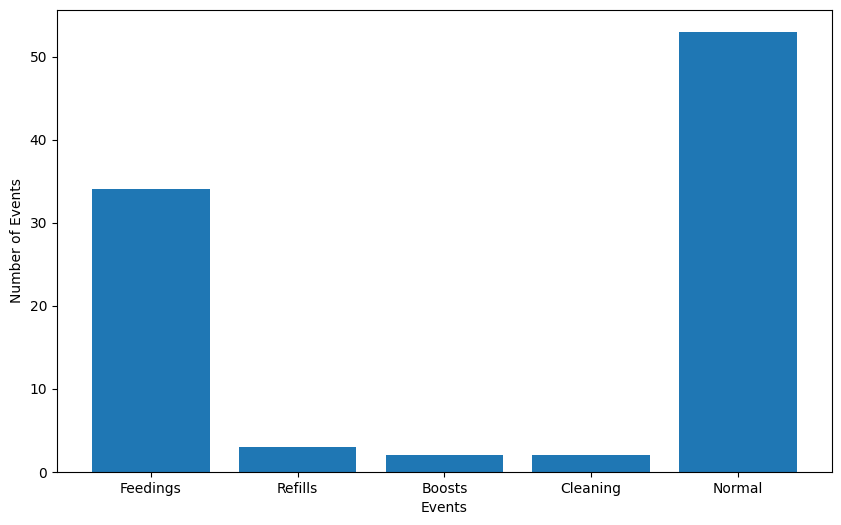

In [15]:
# Plot Numbers of the different events in the training set:

Events = [event for event in ID_DICT.keys()]
Num_of_Events = [len(event_list) for event_list in ID_DICT.values()]

print(Num_of_Events)

# Balkendiagramm erstellen
plt.figure(figsize=(10, 6))
plt.bar(Events, Num_of_Events)

# Diagramm beschriften
plt.xlabel('Events')
plt.ylabel('Number of Events')

# Diagramm anzeigen
plt.show()

Now we need to make the output vector for the training set. This is for training and validating the model. 

In [16]:
def make_y(ID_DICT, event_mapping_dict):
    '''
    This function creates the y vector for the training the model.
    '''

    y = pd.Series([])
    for event, id in ID_DICT.items():
        length = len(id)
        number = event_mapping_dict[event]
        y = pd.concat([y, pd.Series([number] * length)], ignore_index=True, axis=0) 

    return y

In [17]:
event_mapping_dict = {'Normal': 0, 'Feedings': 1, 'Refills': 2, 'Boosts': 3, 'Cleaning': 4}       #Kann an Anfang des Kapitels
reverse_mapping_dict = {value: key for key, value in event_mapping_dict.items()}

y = make_y(ID_DICT, event_mapping_dict)

print(y.shape, train_set.shape)
print(y.head())

(94,) (5640, 5)
0    1
1    1
2    1
3    1
4    1
dtype: int64


C:\Users\Manu\AppData\Local\Temp\ipykernel_7828\1668166392.py:10: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  y = pd.concat([y, pd.Series([number] * length)], ignore_index=True, axis=0)


### Lets get tsfresh going

Now we will extract features using the tsfresh library. This way we will create our first X vector, that we can use to train our models. This Vector consists of so many rows, like there are points used for training. That means a 60 rows (one measurement) gets transfered into one row of data.

In [18]:
from tsfresh import extract_features, select_features
from tsfresh.utilities.dataframe_functions import impute

X = extract_features(train_set, column_id="ID", impute_function=impute, n_jobs=1)
print(f'X_shape: {X.shape}, y_shape: {y.shape}')

In [19]:
import csv
# Extract features:
def get_relevant_features(X, y):
    '''
    This function filters the relevant features from the given data.
    '''

    relevant_features = set()   # define set in order to avoid duplicates

    for label in y.unique():
        y_train_binary = y == label
        X_train_filtered = select_features(X, y_train_binary)
        print("Number of relevant features for class {}: {}/{}".format(label, X_train_filtered.shape[1], X.shape[1]))
        relevant_features = relevant_features.union(set(X_train_filtered.columns))

    print(f'It have been {len(relevant_features)} relevant features found.')
    return relevant_features

Now we can extract the relevant features from out training data. Then we filter our training vector for the relevant features. This reduces the amount of Features needed to train the model from 3132 features to 579 (len(relevant_features)):

We also have the option to save the set to an CSV. Saving is needed if you are setting up a new model, because the extracted and filled X-vectors must always be in the same order. This CSV file can then be used to create the order of the features extracted with tsfresh as when training the model. 

In [38]:
relevant_features = get_relevant_features(X, y)

X_train_filtered = X[list(relevant_features)]
#X_train_filtered = X_train[list(relevant_features)]
#X_test_filtered = X_test[list(relevant_features)]

#print(X_train_filtered.shape, X_test_filtered.shape)

# Save relevant features to csv file:
X_train_filtered.to_csv('X_train_filtered_Versuch_04.csv')

Number of relevant features for class 1: 210/3132
Number of relevant features for class 2: 72/3132
Number of relevant features for class 3: 0/3132
Number of relevant features for class 4: 0/3132
Number of relevant features for class 0: 205/3132
It have been 302 relevant features found.


In [20]:
import pickle

def save_model(model, filename):
    '''
    This function saves the model to a pickle file.
    '''

    pickle.dump(model, open(filename, 'wb'))

def load_model(filename):
    '''
    This function loads the model from a pickle file.
    '''

    model = pickle.load(open(filename, 'rb'))
    return model

### Function for doing GridSearch:

GridSearch is being used in order to find the best Hyperparameters for the given model.

In [39]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold 
from sklearn.tree import DecisionTreeClassifier

# Define the models:
decision_tree_calssifier = DecisionTreeClassifier()
gradient_boosting_classifier = GradientBoostingClassifier()
knn_classifier = KNeighborsClassifier()

# Define the parameters for the grid search:
# Decision Tree:
param_grid_dt = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 6]
}

# Gradient Boosting:
param_grid_gb = {
    'n_estimators': [100, 300],
    'learning_rate': [0.1, 0.02],
    'max_depth': [4, 8],
    'min_samples_leaf': [3, 9],
    'max_features': [1.0, 0.1]
}

# KNN:
param_grid_knn = {
    'n_neighbors': [1, 2, 3, 5],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

def grid_search(model, param_grid, X_train, y_train, n_splits=2, shuffle=True, random_state=42, n_jobs=-1):
    '''
    This function performs a grid search for the given model and the given parameters.
    '''

    cv = StratifiedKFold(n_splits=n_splits, shuffle=shuffle, random_state=42)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=cv, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_params = grid_search.best_params_
    best_score = grid_search.best_score_

    print(type(model))
    print("Best parameters for the Classifier:", best_params)
    print("Best score for the Classifier:", best_score)


# Do the grid search (uncomment for the model you want to use):
#grid_search(decision_tree_calssifier, param_grid_dt, X_train_filtered, y)
#grid_search(gradient_boosting_classifier, param_grid_gb, X_train_filtered, y)
grid_search(knn_classifier, param_grid_knn, X_train_filtered, y)

<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
Best parameters for the Classifier: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
Best score for the Classifier: 0.6276595744680851


## Decision Tree Classifier

### Versuch 1:
Best parameters for the Classifier: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}

Best score for the Classifier: 0.8829284750337383

### Versuch 2:
Best parameters for the Classifier: {'criterion': 'gini', 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}

Best score for the Classifier: 0.8960863697705803

### Versuch 3:
Best parameters for the Classifier: {'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 6, 'min_samples_split': 15}

Best score for the Classifier: 0.8723404255319149

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

#decision_tree_classifier = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2)       # Versuch 1
#decision_tree_classifier = DecisionTreeClassifier(criterion='gini', max_depth=30, min_samples_leaf=1, min_samples_split=2)       # Versuch 2
decision_tree_classifier2 = DecisionTreeClassifier(criterion='gini', max_depth=20, min_samples_leaf=6, min_samples_split=15)       # Versuch 3

decision_tree_classifier2.fit(X_train_filtered, y)

# Save the model to a pickle file:
#save_model(decision_tree_calssifier, 'Versuch_3/Versuch_03_decision_tree_classifier.pkl')

## GradientBoostingClassifier

GridSearch dauert sehr lange, weshalb nicht so viele durchsucht werden.

### Versuch 1:

Best parameters for the Classifier: {'learning_rate': 0.1, 'max_depth': 4, 'max_features': 0.1, 'min_samples_leaf': 3, 'n_estimators': 300}

Best score for the Classifier: 0.9220647773279352

### Versuch 2:
Best parameters for the Classifier: {'learning_rate': 0.02, 'max_depth': 4, 'max_features': 1.0, 'min_samples_leaf': 9, 'n_estimators': 300}

Best score for the Classifier: 0.9352226720647774

### Versuch 3:
Best parameters for the Classifier: {'learning_rate': 0.02, 'max_depth': 4, 'max_features': 0.1, 'min_samples_leaf': 9, 'n_estimators': 300}

Best score for the Classifier: 0.9148936170212766

In [38]:
from sklearn.ensemble import GradientBoostingClassifier

#gradient_boosting_classifier = GradientBoostingClassifier(learning_rate=0.1, max_depth=4, min_samples_leaf=3, max_features=0.1, n_estimators=300)     # Versuch 1
#gradient_boosting_classifier = GradientBoostingClassifier(learning_rate=0.02, max_depth=4, min_samples_leaf=9, max_features=1.0, n_estimators=300)      # Versuch 2
gradient_boosting_classifier2 = GradientBoostingClassifier(learning_rate=0.02, max_depth=4, min_samples_leaf=9, max_features=0.1, n_estimators=300)      # Versuch 3
gradient_boosting_classifier2.fit(X_train_filtered, y)

# Save the model to a pickle file:
#save_model(gradient_boosting_classifier, 'Versuch_3/Versuch_03_Gradient_Boosting.pkl')

GradientBoostingClassifier(learning_rate=0.02, max_depth=4, max_features=0.1,
                           min_samples_leaf=9, n_estimators=300)

## k-nearest neighbor

### Versuch 1
Best parameters for the Classifier: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}

Best score for the Classifier: 0.7526990553306343

### Versuch 2:
Best parameters for the Classifier: {'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}

Best score for the Classifier: 0.7526990553306343

### Versuch 3:

Best parameters for the Classifier: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'uniform'}

Best score for the Classifier: 0.648936170212766


In [40]:
from sklearn.neighbors import KNeighborsClassifier      # Is just needed so we don't forget to import it when not using the grid search

#k_neighbors_classifier = KNeighborsClassifier(n_neighbors=2, weights='uniform', algorithm='auto', metric='manhattan', p=1)     # Versuch 1
#k_neighbors_classifier = KNeighborsClassifier(n_neighbors=2, weights='uniform', algorithm='auto', metric='euclidean', p=1)     # Versuch 2
k_neighbors_classifier2 = KNeighborsClassifier(n_neighbors=2, weights='uniform', algorithm='auto', metric='manhattan', p=1)     # Versuch 3
k_neighbors_classifier2.fit(X_train_filtered, y)

#print(classification_report(y_test, k_neighbors_classifier.predict(X_test_filtered)))

# Save the model to a pickle file:
#save_model(k_neighbors_classifier2, 'Versuch_3/Versuch_03_k_NN_classifier.pkl')

KNeighborsClassifier(metric='manhattan', n_neighbors=2, p=1)

# Use the model

In order to use the model we first have to bring our given data into same format as we did it while training. So that means that we will create a DataFrame, with the coloums ['ID', 'pH', 'EC', 'ORP']. The ID value will always be 0 because for testing, we test one set consisting of #WINDOW_SIZE samples. 

In [22]:
def make_test_set(data, start_date, end_date, test_set_columns=['ID', 'pH', 'EC', 'ORP', 'Temperature'], ID=0):
    '''
    This function creates a test set for the given data and the given time window.
    It returns the test set.
    '''
    
    test_data = data.loc[start_date:end_date]
    test_set = pd.DataFrame(columns=test_set_columns)
    test_set['pH'] = test_data['pH']
    test_set['EC'] = test_data['EC']
    test_set['ORP'] = test_data['ORP']
    test_set['Temperature'] = test_data['Temperature']
    test_set['ID'] = ID
    test_set = test_set.reset_index(drop=True)    # make sure the index is set right

    return test_set

def sort_X(X, columns: list[str]):
    '''
    This function sorts the X Dataframe in the same way as the X_train_used.csv
    This is necessary because the order of the features is important for the model
    Otherwise it can not be used for classification.
    '''

    new_data_frame = pd.DataFrame(columns=columns)

    # drop first  coloumn of new dataframe
    new_data_frame = new_data_frame.drop(columns=['Unnamed: 0'])

    # Add the Values from X to the dataframe
    for name in X.columns:
        if name in columns:
            new_data_frame[name] = X[name]

    return new_data_frame

In [23]:
# Make for each event one test set:
TEST_SET1 = make_test_set(complete_data, start_date='2024-01-29 09:21:52', end_date='2024-01-29 12:19:20', ID=0)  # Boost + Refill
TEST_SET2 = make_test_set(complete_data, start_date='2024-02-04 14:10:15', end_date='2024-02-04 17:07:45', ID=1)  # Normal
TEST_SET3 = make_test_set(complete_data, start_date='2024-02-02 10:28:41', end_date='2024-02-02 13:26:09', ID=2)  # Feeding1
TEST_SET4 = make_test_set(complete_data, start_date='2024-02-06 10:29:46', end_date='2024-02-06 13:27:15', ID=3)  # Feeding2
TEST_SET5 = make_test_set(complete_data, start_date='2024-02-06 01:46:20', end_date='2024-02-06 04:43:49', ID=4)  # Normal
TEST_SET6 = make_test_set(complete_data, start_date='2024-02-01 21:29:34', end_date='2024-02-02 00:27:04', ID=6)  # Normal
TEST_SET7= make_test_set(complete_data, start_date='2024-02-05 00:11:56', end_date='2024-02-05 03:09:25', ID=7)  # Normal

# Concatenate the test sets:
TEST_SET = pd.concat([TEST_SET1, TEST_SET2, TEST_SET3, TEST_SET4, TEST_SET5, TEST_SET6, TEST_SET7], ignore_index=True, axis=0)

# Extract the features from the test set and filter them according to the relevant features:
X_test = extract_features(TEST_SET, column_id="ID", impute_function=impute, n_jobs=1)
X_test_filtered_columns = pd.read_csv('X_train_filtered_Versuch_04.csv').columns
X_test_filtered = sort_X(X_test, X_test_filtered_columns)        # hier muss dann noch die Reihenfolge angepasst werden

# Create the y_test vector:
y_test = pd.Series([2, 0, 1, 1, 0, 0, 0])

print(TEST_SET.shape)
print(TEST_SET.head(5))

Feature Extraction:   0%|          | 0/28 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 28/28 [00:02<00:00, 12.82it/s]


(420, 5)
   ID     pH      EC    ORP  Temperature
0   0  5.918  2321.0  134.3         16.1
1   0  5.925  2321.0  127.0         16.1
2   0  5.912  2321.0  126.3         16.1
3   0  5.916  2321.0  137.0         16.1
4   0  5.912  2321.0  124.7         16.1


In [40]:
print(classification_report(y_test, decision_tree_classifier2.predict(X_test_filtered)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



In [43]:
print(classification_report(y_test, k_neighbors_classifier2.predict(X_test_filtered)))

              precision    recall  f1-score   support

           0       0.60      0.75      0.67         4
           1       0.00      0.00      0.00         2
           2       1.00      1.00      1.00         1

    accuracy                           0.57         7
   macro avg       0.53      0.58      0.56         7
weighted avg       0.49      0.57      0.52         7



In [42]:
print(classification_report(y_test, gradient_boosting_classifier2.predict(X_test_filtered)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         4
           1       1.00      1.00      1.00         2
           2       1.00      1.00      1.00         1

    accuracy                           1.00         7
   macro avg       1.00      1.00      1.00         7
weighted avg       1.00      1.00      1.00         7



# Compare different models.

Vielleicht kann man ja ne Funktion schreiben 'use_model', welches auch ein Dict oder sowas nimmt, und dann die unterschiedlichen Ergebnisse anzeigt....

In [44]:
def simulate(data, start_date, end_date, reverse_mapping_dict, classifiers, filter_coloums, WINDOW_SIZE=60):
    '''
    This function simulates the use of the model. It takes the data, a starting and end point and testes the model for each time step.
    It returns the predicted event and the corresponding probability.
    '''

    simulate_data = data.loc[start_date:end_date]
    
    # Create a DataFrame to save the results
    results = pd.DataFrame(columns=['time'])
    for classifier in classifiers:
        results[classifier.__class__.__name__] = None       # Add a column for each classifier
    
    # Now extract the features from the data:
    for i in range(len(simulate_data)-WINDOW_SIZE):
        TEST_SET = make_test_set(data, start_date=simulate_data.index[i], end_date=simulate_data.index[i+WINDOW_SIZE])
        X_test = extract_features(TEST_SET, column_id="ID", impute_function=impute, n_jobs=1)
        X_test_filtered = sort_X(X_test, filter_coloums)        # Filter for relevant features
        new_row = {'time': simulate_data.index[i+WINDOW_SIZE]}
        
        # Make the prediction for each classifier:
        for classifier in classifiers:
            out = classifier.predict(X_test_filtered)
            predicted_event = reverse_mapping_dict.get(out[0], 'Unbekannt') 
            new_row[classifier.__class__.__name__] = predicted_event        # Add predicted event to the new row
            print(f'Predicted event from {classifier.__class__.__name__} at {simulate_data.index[i+WINDOW_SIZE]}: {predicted_event}')

        results.loc[len(results)] = new_row
        new_row = {}

    # Set time as index
    results.set_index('time', inplace=True)
    return results

In [24]:
import joblib

decision_tree_classifier = joblib.load('Versuch_3/Versuch_03_decision_tree_classifier.pkl')
gradient_boosting_classifier = joblib.load('Versuch_3/Versuch_03_Gradient_Boosting.pkl')
k_neighbors_classifier = joblib.load('Versuch_3/Versuch_03_k_NN_classifier.pkl')

In [29]:
test_set = make_test_set(complete_data, start_date='2024-02-02 10:28:41', end_date='2024-02-02 13:26:09', ID=0)
X_test = extract_features(test_set, column_id="ID", impute_function=impute, n_jobs=1)
X_test_filtered = sort_X(X_test, filter_coloums)

Feature Extraction:   0%|          | 0/4 [00:00<?, ?it/s]

Feature Extraction: 100%|██████████| 4/4 [00:00<00:00, 12.50it/s]


In [32]:
%%timeit
k_neighbors_classifier.predict(X_test_filtered)

6.93 ms ± 113 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [26]:
import sys

# These are the usual ipython objects, including this one you are creating
ipython_vars = ["In", "Out", "exit", "quit", "get_ipython", "ipython_vars"]

# Get a sorted list of the objects and their sizes
mem = {
    key: value
    for key, value in sorted(
        [
            (x, sys.getsizeof(globals().get(x)))
            for x in dir()
            if not x.startswith("_") and x not in sys.modules and x not in ipython_vars
        ],
        key=lambda x: x[1],
        reverse=True,
    )
}

mem

{'complete_data': 2506600,
 'old_data': 1433672,
 'train_set': 383684,
 'X_train_used': 228020,
 'X_test_filtered_columns': 39574,
 'filter_coloums': 39574,
 'new_data': 32704,
 'X_test': 25096,
 'TEST_SET': 16964,
 'TEST_SET1': 2564,
 'TEST_SET2': 2564,
 'TEST_SET3': 2564,
 'TEST_SET4': 2564,
 'TEST_SET5': 2564,
 'TEST_SET6': 2564,
 'TEST_SET7': 2564,
 'test_set': 2564,
 'X_test_filtered': 2456,
 'DecisionTreeClassifier': 1688,
 'y': 916,
 'normal_dates': 488,
 'important_dates': 296,
 'reverse_mapping_dict': 224,
 'y_test': 220,
 'feeding_dates_complete': 200,
 'ID_DICT': 184,
 'event_mapping_dict': 184,
 'classification_report': 152,
 'create_train_set': 152,
 'extract_features': 152,
 'feeding_amounts': 152,
 'get_data_from_API': 152,
 'get_data_from_CSV': 152,
 'get_relevant_features': 152,
 'impute': 152,
 'load_model': 152,
 'make_test_set': 152,
 'make_y': 152,
 'merge_data': 152,
 'open': 152,
 'plot_data': 152,
 'remove_outliers': 152,
 'remove_outliers2': 152,
 'save_model':

In [ ]:
# Decision Tree:
CPU_times_DT = [0, 0, 0, 0, 0]      # ns
Wall_times_DT = [7.51, 9.1, 10.5, 8.51, 8.27]     # ms

In [ ]:
train_set = pd.read_csv('Versuch_3/Versuch_03_train_set.csv')

ID_DICT = {'Feedings': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16], 'Refills': [17, 18, 19], 'Boosts': [20, 21], 'Cleaning': [22, 23], 'Normal': [24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]}

event_mapping_dict = {'Normal': 0, 'Feedings': 1, 'Refills': 2, 'Boosts': 3, 'Cleaning': 4}       #Kann an Anfang des Kapitels
reverse_mapping_dict = {value: key for key, value in event_mapping_dict.items()}

y = make_y(ID_DICT, event_mapping_dict)

X = extract_features(train_set, column_id="ID", impute_function=impute, n_jobs=1)
X_train_used = pd.read_csv('Versuch_1/X_train_filtered_Versuch_01.csv')
X_train_filtered = sort_X(X, X_train_used.columns)

decision_tree_classifier.fit(X_train_filtered, y)

In [ ]:
# Never seen events:

#feeding1 = ['2024-02-02 11:28:51']
# start_date='2024-02-02 08:01:16', end_date='2024-02-02 15:59:34',         # 100 predictions Time Window = 60
# start_date='2024-02-02 06:00:57', end_date='2024-02-02 15:59:34',         # 100 predictions Time Window = 100  

#feeding2 = ['2024-02-06 11:29:56']
# start_date='2024-02-06 07:56:21', end_date='2024-02-06 14:36:27',        

# Refills/Boost = ['2024-01-29 10:52:06']
# start_date='2024-01-29 07:39:35', end_date='2024-01-29 15:37:51',         # Time Window = 60
# start_date='2024-01-29 05:39:16', end_date='2024-01-29 15:37:51',         # Time Window = 100

# MiniBoost = ['2024-02-04 10:45:43']
# start_date='2024-02-04 07:15:09', end_date='2024-02-04 15:13:26',         # 100 predictions

# Normal:
# start_date='2024-02-04 13:10:05', end_date='2024-02-04 21:08:26',         # Time Window = 60
# start_date='2024-02-04 11:09:47', end_date='2024-02-04 21:08:26',         # Time Window = 100

# Only Little Boost:
# start_date='2024-02-04 07:39:13', end_date='2024-02-04 15:37:30',

# Refill = ['2024-02-08 07:19:32']
# start_date='2024-02-08 03:48:58', end_date='2024-02-08 12:17:28',

# LongTerm:
# start_date='2024-02-06 06:29:06', end_date='2024-02-08 12:17:28',         # Time Window = 60

#LongLongTerm
# start_date='2024-01-29 00:02:24', end_date='2024-02-08 12:17:28',

In [28]:
import pandas as pd
# Get the used X_train_filtered, so we can sort the extracted features in the same way
X_train_used = pd.read_csv('Versuch_3\X_train_filtered_Versuch_03.csv')
filter_coloums = X_train_used.columns

results = simulate(complete_data, start_date='2024-02-08 03:48:58', end_date='2024-02-08 12:17:28', classifiers=[k_neighbors_classifier2], reverse_mapping_dict=reverse_mapping_dict, filter_coloums=filter_coloums, WINDOW_SIZE=60)

# Save the results to a csv file:
#results.to_csv('Versuch_3/Versuch_03_Complete_LongLongTerm.csv')

## Vizualize Results

Now we can create a plot out of the results. The event_mapping_dict can be used in order to 'translate' the strings into a number. This shall help see how often the models fluctuate between the events.

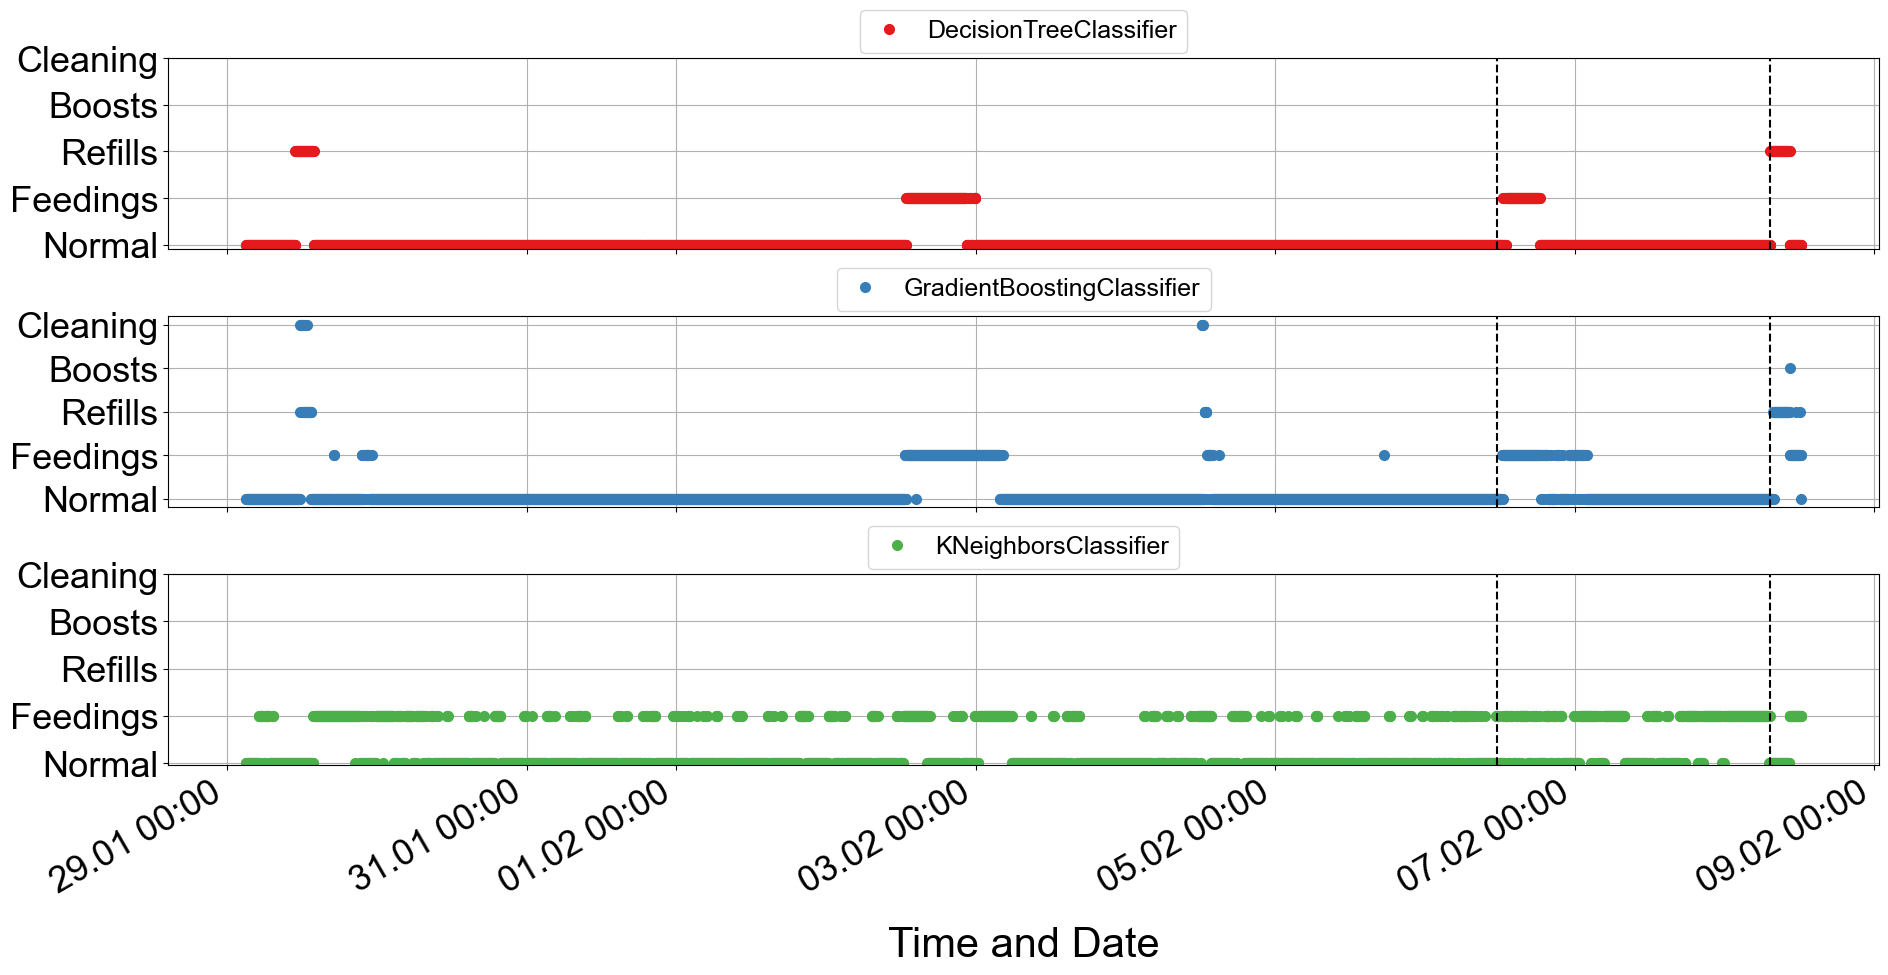

In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md

colors = sns.color_palette("Set1", n_colors=3)

# Read results from CSV

feeding_results = pd.read_csv('Versuch_3/Versuch_03_Complete_Feeding.csv', index_col=0, parse_dates=True)
feeding_results.index = pd.to_datetime(feeding_results.index)

normal_results = pd.read_csv('Versuch_3/Versuch_03_Complete_Normal.csv', index_col=0, parse_dates=True)
normal_results.index = pd.to_datetime(normal_results.index)

refill_results = pd.read_csv('Versuch_3/Versuch_03_Complete_Refill.csv', index_col=0, parse_dates=True)
refill_results.index = pd.to_datetime(refill_results.index)

long_term = pd.read_csv('Versuch_3/Versuch_03_Complete_LongLongTerm.csv', index_col=0, parse_dates=True)
long_term.index = pd.to_datetime(long_term.index)

# Just in case redefine the event mapping dict
event_mapping_dict = {'Normal': 0, 'Feedings': 1, 'Refills': 2, 'Boosts': 3, 'Cleaning': 4} 

# Replace strings with numbers:
feeding_results_numeric = feeding_results.apply(lambda col: col.map(event_mapping_dict))
normal_results_numeric = normal_results.apply(lambda col: col.map(event_mapping_dict))
refill_results_numeric = refill_results.apply(lambda col: col.map(event_mapping_dict))
long_term_numeric = long_term.apply(lambda col: col.map(event_mapping_dict))

# Plot the results:
def plot_results(results, mapping_dict=event_mapping_dict, colors=['red', 'green', 'blue'], events=[]):
    subplot_number = 1
    number_of_subplots = len(results.columns)
    plt.figure('Results', figsize=(19, 10))

    for model in results.columns:
        plt.subplot(number_of_subplots, 1, subplot_number)
        plt.plot(results.index, results[model], label=model, marker='o', markersize=7, linestyle='', color=colors[subplot_number-1])
        
        for event in events:
            plt.axvline(x=pd.to_datetime(event), color='black', linestyle='--', linewidth=1.5)

        ax = plt.gca()
        xfmt = md.DateFormatter('%d.%m %H:%M')       # Format of the x-axis labels
        ax.xaxis.set_major_formatter(xfmt)
        plt.xlabel("Date and time")
        plt.gcf().autofmt_xdate()   # Rotate the x-axis labels for better readability
        plt.tight_layout(pad=0.8)
        plt.xlabel('Time and Date')
        #plt.ylabel('Event')
        plt.yticks(list(mapping_dict.values()), list(mapping_dict.keys()))
        plt.grid()
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.32))
        subplot_number += 1

    # Settings
    plt.rcParams['font.sans-serif'] = 'Arial'
    plt.rcParams['font.size'] = 14             # general font size
    plt.rcParams['axes.titlesize'] = 30        # axis title size
    plt.rcParams['axes.labelsize'] = 30        # y axis label size
    plt.rcParams['xtick.labelsize'] = 26       # x tick label size
    plt.rcParams['ytick.labelsize'] = 26       # y tick label size
    plt.rcParams['legend.fontsize'] = 18
    plt.rcParams['legend.handlelength'] = 1.5
    plt.rcParams['figure.titlesize'] = 14 
    plt.rcParams['axes.labelpad'] = 20
    #plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=number_of_subplots)
    plt.subplots_adjust(hspace=0.35)
    plt.savefig('Versuch_3/Versuch_03_Complete_LongLongTerm.pdf')
    plt.show()

#plot_results(boost_and_refill_numeric, colors=colors, events=['29.01.2024 10:52'])
#plot_results(feeding_results_numeric, colors=colors, events=['02.02.2024 11:28'])
#plot_results(refill_results_numeric, colors=colors, events=['2024-02-08 07:19:32'])
#plot_results(miniboost_results_numeric, colors=colors, events=['2024-02-04 10:45:43'])
#plot_results(normal_results_numeric, colors=colors)
plot_results(long_term_numeric, colors=colors, events=test_dates[-3:-1])       #For only LongTerm: ['2024-02-06 11:29:56', '2024-02-08 07:19:32']